In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torchtext.vocab import GloVe
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import SubsetRandomSampler,DataLoader
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



EMBED_DIM = 300 
ENC_BIDIRECTIONAL = True
ENC_BIDIRECTIONAL_FACTOR = 2 if ENC_BIDIRECTIONAL else 1
ENC_HIDDEN_DIM = 256
DEC_HIDDEN_DIM  = 256
ENC_OUTPUT_DIM =  DEC_HIDDEN_DIM
DEC_EMBED_DIM = 300

BATCH_SIZE = 64

device_cpu = torch.device('cpu')
device_fast = torch.device('cpu')

if torch.has_mps:
    device_fast = torch.device('mps')
elif torch.has_cuda:
    device_fast = torch.device('cuda')


output_index_to_word = {}
output_vocab = {}
for i in range(0,10):
    output_vocab[str(i)] = i
    output_index_to_word[i] = str(i)
output_vocab['-'] = 10
output_index_to_word[10] = '-'
output_vocab['<sos>'] = 11
output_index_to_word[11] = '<sos>'
output_vocab['<eos>'] = 12
output_index_to_word[12] = '<eos>'

glove = GloVe()

In [3]:

def get_training_data(filename='./Assignment4aDataset.txt',glove=glove):
    f = open(filename,'r')
    dataset = []
    for line in f.readlines():       
         
        nl_date , out_date = line.split(',')
        nl_date = nl_date.replace("\'","").strip()
        out_date = out_date.replace("\'","").strip()

        split_on_slash = nl_date.split("/")
        nl_date = " / ".join(split_on_slash)

        embeddings = []
        for word in nl_date.split(' '):
            embeddings.append(glove[word])
        
        current_inp_length = len(embeddings)
        embeddings = torch.stack(embeddings)

        target = []
        target.append(output_vocab['<sos>'])

        for character in list(out_date):
            target.append(output_vocab[character])
        
        target.append(output_vocab['<eos>'])

        dataset.append({'in' : embeddings,'in_length' : current_inp_length,'out' : target})
    return dataset


class TranslationDataset(Dataset):
    def __init__(self,data):
        super().__init__()
        self.data = data


    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)


def collate_function(batch_data):
    inputs = [b['in'] for b in batch_data]
    in_lengths = [b['in_length'] for b in batch_data]
    out = torch.tensor([b['out'] for b in batch_data])
    inputs = pad_sequence(inputs,batch_first=True)
    return {'src': inputs, 'src_length' : in_lengths, 'trg' : out}




In [4]:
train_dataset = TranslationDataset(get_training_data())

train_idx,valid_idx = train_test_split(np.arange(len(train_dataset)), 
    test_size=0.2,
    shuffle= True,
    random_state=0
)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_dataloader = DataLoader(train_dataset,BATCH_SIZE,sampler=train_sampler,collate_fn=collate_function)
valid_dataloader = DataLoader(train_dataset,BATCH_SIZE,sampler=valid_sampler,collate_fn=collate_function)

In [5]:
class Encoder(nn.Module):

    def __init__(self,embed_dim = EMBED_DIM,enc_hidden_dim = ENC_HIDDEN_DIM,enc_output_dim = ENC_OUTPUT_DIM,NUM_LAYERS=1,enc_bidirectional=ENC_BIDIRECTIONAL,dropout=0.3):
        super().__init__()
        
        #self.embedding_layer = nn.Embedding(vocab_size,EMBED_DIM)
        self.rnn = nn.GRU(embed_dim,enc_hidden_dim, num_layers = NUM_LAYERS ,batch_first= True ,bidirectional=enc_bidirectional)


        # ENCODER_OUTPUT_DIM = DECODER_HIDDEN_SIZE
        self.fc = nn.Linear(2*enc_hidden_dim,enc_output_dim) 

        self.fc_out = nn.Linear(enc_output_dim,1)
        nn.init.xavier_uniform_(self.fc.weight)
        self.dropout = nn.Dropout(dropout)

    def forward(self,inp,inp_len):
        
        #embedded_input = self.embedding_layer(inp)
        embedded_input = inp   # [batch_size, input_seq_length, embed_dim ]
        
        packed_embedding = nn.utils.rnn.pack_padded_sequence(embedded_input,inp_len,batch_first=True,enforce_sorted=False)
        packed_output , hidden = self.rnn(packed_embedding)  # hidden = [D*num_layers, batch_size , hidden_dim ]
        outputs, _  = nn.utils.rnn.pad_packed_sequence(packed_output,batch_first=True)  # [batch_size, inp_seq_length, hidden_dim]
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1)))  # [batch_size, decoder_hidden_size]
        return outputs,hidden

In [ ]:
batch_data = next(iter(train_dataloader))

In [6]:
class Attention(nn.Module):
    def __init__(self,enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        
        self.attn = nn.Linear(enc_hidden_dim+dec_hidden_dim,dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim,1)

    def forward(self,hidden,encoder_outputs, encoder_length_mask):
        
        # encoder_outputs = [batch_size,seq_length, enc_hidden_dim][2*ENCODER_HIDDEN_DIM or ENCODER_HIDDEN_DIM]
        # hidden = [batch_size,  dec_hidden_dim]
        # encoder_length_mask = [batch_size, seq_length]

        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        h = hidden.unsqueeze(1).repeat(1,src_len,1)  # h = [batch_size,seq_length,dec_hidden_dim]
        energy = torch.tanh(self.attn(torch.cat((h,encoder_outputs),dim=2)))  #[batch_size,seq_length,dec_hidden_dim]
        attention_scores = self.v(energy).squeeze(2)  # attention_scores = [batch_size , seq_length ]
        attention_scores = attention_scores.masked_fill(encoder_length_mask==1, -1e10)   # Fill padding tokens with a lower value
        attention_scores = F.softmax(attention_scores,dim=1)
        return attention_scores

In [ ]:
def create_mask(src_lengths,max_src_length):

        src_mask = torch.zeros((len(src_lengths),max_src_length),dtype=torch.int64)
        for i in range(len(src_lengths)):

            src_mask[i,src_lengths[i]:] = 1
        return src_mask

enc = Encoder(30,30,15,10)

inp = torch.randn((3,20,30))
inp_len = [20 for i in range(3)]
outputs, hidden = enc(inp,inp_len)
outputs

In [7]:
class Decoder(nn.Module):

    def __init__(self,vocab_size,enc_hidden_dim,dec_hidden_dim,dec_output_dim,emb_dim):
        
        # enc_hidden_dim = 2*ENCODER_HIDDEN_DIM or ENCODER_HIDDEN_DIM

        super().__init__()
        
        self.vocab_size = vocab_size
        self.attention = Attention(enc_hidden_dim,dec_hidden_dim)
        self.embedding_layer = nn.Embedding(vocab_size,emb_dim)
        self.rnn = nn.GRU(enc_hidden_dim + emb_dim,dec_hidden_dim,batch_first = True)

        self.fc_out = nn.Linear(enc_hidden_dim + emb_dim + dec_hidden_dim , dec_output_dim)
        
        #self.fc_tilde = nn.Linear(enc_hidden_dim + emb_dim + dec_hidden_dim , dec_hidden_dim)
        #self.max_out_layer = nn.MaxPool1d(kernel_size=2)
        #self.W0 = nn.Linear(dec_hidden_dim>>1,emb_dim)
        #self.prob_out = nn.Linear(emb_dim,vocab_size)
        #self.prob_out.weight = self.embedding_layer.weight
        

    def forward(self,input,hidden,encoder_outputs,encoder_length_mask):
            # encoder outputs =  batch_size , seq_len , encoder_output_dim
            # hidden = batch_size , hidden_dim
            # input = batch_size
            
            input = input.unsqueeze(0) # [1,batch_size]
            embedded = self.embedding_layer(input) # [1,batch_size,embed_dim]

            embedded = embedded.permute(1,0,2) #[ batch_size, seq_length=1, embed_dim ]

            attention_vector = self.attention(hidden,encoder_outputs,encoder_length_mask) # [ batch_size , seq_length ]
            attention_vector = attention_vector.unsqueeze(1) # [batch_size , 1 , seq_length ]

            weighted = torch.bmm(attention_vector,encoder_outputs) # [ batch_size, 1, encoder_output_dim]
            #weighted = weighted.permute(1,0,2) #[1 , batch_size , encoder_output_dim]


            rnn_input = torch.cat((embedded,weighted),dim=2) #[batch_size, seq_length=1, encoder + decoder]

            out,h = self.rnn(rnn_input,hidden.unsqueeze(0)) # consider only a single layer (1.) so unsqueeze(0)

            # out = [batch_size, seq_length = 1, decoder_hidden_out (bidirectional)]
            # hidden = [D*num_layers,batch_size, decoder_hidden_out]


            embedded = embedded.squeeze(1)  # [batch_size,embed_dim]
            out = out.squeeze(1)    #[batch_size, decoder_hidden_out] # Have to change if the number of layers is changed to more than 1
            weighted = weighted.squeeze(1)  # [batch_size,encoder_output_dim] 
            prediction = self.fc_out(torch.cat([embedded,out,weighted],dim=1)) #[batch_size, decoder_output_dim]
            #prediction = F.softmax(self.fc_out(torch.cat([embedded,out,weighted],dim=1)),dim=1) #[batch_size, decoder_output_dim]
            #t_tilde =  self.fc_tilde(torch.cat([embedded,out,weighted],dim=1)) # [batch_size, decoder_hidden_dim]
            #t_tilde = self.max_out_layer(t_tilde.unsqueeze(1)) #[batch_size,1,decoder_hidden_dim/2]
            #t_tilde = t_tilde.squeeze(1)

            #inter_step  = self.W0(t_tilde) # [ batch_size , dec_embeddim]
            #prediction = self.prob_out(inter_step) #[  batch_size , vocab_size]
            #prediction = F.softmax(prediction,dim=1)
            return prediction, h.squeeze(0), attention_vector # Reduce the number of layers

In [ ]:
max_out_layer = nn.MaxPool1d(2)
output = torch.randn((3,1,10))


In [ ]:
output

In [ ]:
enc = Encoder()
dec = Decoder(13,2*ENC_HIDDEN_DIM,DEC_HIDDEN_DIM,13,300)

In [ ]:


encoder_mask  = create_mask(batch_data['src_length'],max(batch_data['src_length']))
enc_outputs , hidden = enc(batch_data['src'],batch_data['src_length'])

predictions , hidden = dec(torch.randint(13,(BATCH_SIZE,)),hidden,enc_outputs,encoder_mask)


In [8]:
class TranslationModel(nn.Module):

    def __init__(self,
                input_embed_dim = EMBED_DIM,
                encoder_hidden_dim = ENC_HIDDEN_DIM,
                encoder_hidden_output = ENC_OUTPUT_DIM,
                enc_num_layers = 1,
                enc_bidirectional = ENC_BIDIRECTIONAL,

                dec_vocab_size = len(output_vocab),
                dec_embed_dim = DEC_EMBED_DIM,
                dec_hidden_dim  =DEC_HIDDEN_DIM,
                device_train = device_cpu
        ):
        
        super().__init__()

        self.encoder = Encoder(input_embed_dim,encoder_hidden_dim,encoder_hidden_output,enc_num_layers,enc_bidirectional=enc_bidirectional)
        enc_bidirectional_factor = 2 if enc_bidirectional else 1
        self.decoder = Decoder(dec_vocab_size,enc_bidirectional_factor*encoder_hidden_dim,dec_hidden_dim=dec_hidden_dim,dec_output_dim=dec_vocab_size,emb_dim=dec_embed_dim)
        self.device_train = device_train


    def create_mask(self, src_lengths,max_src_length):

        src_mask = torch.zeros((len(src_lengths),max_src_length),dtype=torch.int64)
        for i in range(len(src_lengths)):

            src_mask[i,src_lengths[i]:] = 1
        return src_mask
        
    def forward(self,source,source_len,target,teacher_forcing_ratio = 0.0):
        #   source = [batch_size, max_src_len]
        #   source_len = [length of sentence in the batch]
        #   target = [batch_size,traget_length]
        #   teacher_forcing_ratio = probability to use teacher forcinbg

        batch_size = source.shape[0]
        target_length = target.shape[1]
        target_vocab_size = self.decoder.vocab_size
        outputs= torch.zeros(batch_size,target_length,target_vocab_size).to(self.device_train)
        encoder_outputs , hidden = self.encoder(source,source_len)

        inp = target[:,0]        
        enc_mask = self.create_mask(source_len,int(encoder_outputs.shape[1]))
        for t in range(1,target_length):
            decoder_output, hidden, attention_vector =  self.decoder(inp,hidden,encoder_outputs,enc_mask)

            outputs[:,t,:] = decoder_output # batch_size, vocab_size
            teacher_force = random.random() < teacher_forcing_ratio 

            top1 = decoder_output.argmax(1)

            inp = target[:,t] if teacher_force else top1
        
        return outputs

In [9]:
def apply_weights(model):
    
    for name,param in model.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data,mean=0,std=0.01)
        else:
            nn.init.constant_(param.data,0)

In [ ]:
t = TranslationModel()
t.apply(apply_weights)
batch_data = next(iter(train_dataloader))

criterion = nn.CrossEntropyLoss(ignore_index=output_vocab['<eos>'])
optimizer = optim.Adam(t.parameters(),lr=0.001)


In [ ]:


model_output = t(batch_data['src'],batch_data['src_length'],batch_data['trg'])


model_out_reshaped = model_output[1:].view(-1,model_output.shape[-1])
reshaped_target = batch_data['trg'][1:].view(-1)
loss_value = criterion(model_out_reshaped,reshaped_target)
loss_value.backward()
nn.utils.clip_grad_norm_(t.parameters(),5)
optimizer.step()
print(loss_value.item())

In [ ]:
print(batch_data['trg'])

In [10]:
def train_model(model,num_epochs,train_loader,valid_loader,optimizer,criterion,checkpoint_name='translation_model.pth'):
    

    best_validation_loss = 1000.0
    for e in range(num_epochs):

        training_loss = 0.0
        model.train()
        for i,batch in enumerate(train_loader):

            source, source_length, target = batch['src'], batch['src_length'], batch['trg']

            optimizer.zero_grad()

            # model_output = [batch_size, output_seq_length,vocab_size]
            model_output  = model(source,source_length,target)
            
            model_out_reshaped = model_output[1:].view(-1,model_output.shape[-1])
            reshaped_target = target[1:].view(-1)

            loss_value = criterion(model_out_reshaped,reshaped_target)
            loss_value.backward()
            nn.utils.clip_grad_norm_(model.parameters(),5)

            optimizer.step()
            training_loss += loss_value.item()
        
        print("Epoch " + str(e) + " Training Loss Value = " + str(training_loss/len(train_loader)))
        
        model.eval()
        validation_loss = 0.0

        with torch.no_grad():

            for i, batch in enumerate(valid_loader):
                source, source_length, target = batch['src'], batch['src_length'], batch['trg']
                model_output  = model(source,source_length,target,0)
                model_out_reshaped = model_output[1:].view(-1,model_output.shape[-1])
                reshaped_target = target[1:].view(-1)
                loss_value = criterion(model_out_reshaped,reshaped_target)

                validation_loss += loss_value.item()
        averaged_validation_loss = validation_loss/len(valid_loader)
        print("Epoch " + str(e) + "Validation Loss Value = " + str(averaged_validation_loss))
        print("")
        if (averaged_validation_loss <= best_validation_loss):
            best_validation_loss = averaged_validation_loss
            torch.save(model.state_dict(),checkpoint_name)
    

In [11]:
t = TranslationModel()
t.apply(apply_weights)
train_model(t,50,train_dataloader,valid_dataloader,optim.Adam(t.parameters(),lr=0.01),nn.CrossEntropyLoss())

Epoch 0 Training Loss Value = 0.5157774696350098
Epoch 0Validation Loss Value = 0.26869440615177154

Epoch 1 Training Loss Value = 0.3249284700155258
Epoch 1Validation Loss Value = 0.2687932537794113

Epoch 2 Training Loss Value = 0.2419094487130642
Epoch 2Validation Loss Value = 0.2375465840101242

Epoch 3 Training Loss Value = 1.3447464601397514
Epoch 3Validation Loss Value = 2.0580299339294434

Epoch 4 Training Loss Value = 0.9694382290840149
Epoch 4Validation Loss Value = 0.4787767434120178

Epoch 5 Training Loss Value = 0.3792950532436371
Epoch 5Validation Loss Value = 0.3936197602748871

Epoch 6 Training Loss Value = 0.3478185900449753
Epoch 6Validation Loss Value = 0.2913986191749573

Epoch 7 Training Loss Value = 0.5647434580326081
Epoch 7Validation Loss Value = 0.3168922102451324



KeyboardInterrupt: 

In [23]:
def translate_sentence(sentence, model, max_len = 10,glove=glove):

    model.eval()
    nl_date = sentence.replace("\'","").strip()
    split_on_slash = nl_date.split("/")


    embeddings = []
    for word in nl_date.split(' '):
        embeddings.append(glove[word])
        
    current_inp_length = len(embeddings)
    inp_embeddings = torch.stack(embeddings)
    inp_embeddings = inp_embeddings.unsqueeze(0)

    with torch.no_grad():
       
        encoder_outputs, hidden = model.encoder(inp_embeddings, [current_inp_length])
        mask = model.create_mask([current_inp_length],max([current_inp_length]))
        attentions = torch.zeros(max_len, 1, inp_embeddings.shape[1])
        trg_indexes = []
        for i in range(max_len):

            if i==0:
                trg_tensor = torch.LongTensor([output_vocab['<sos>']])
                
            with torch.no_grad():
                # input,hidden,encoder_outputs,encoder_length_mask
                output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

            attentions[i] = attention
            
            pred_token = output.argmax(1).item()
        
            trg_indexes.append(pred_token)
            trg_tensor = torch.LongTensor([pred_token])

            if pred_token == output_vocab['<eos>']:
                break
    
    trg_tokens = [output_index_to_word[i] for i in trg_indexes]
    return trg_tokens, attentions
    #print(trg_tokens)



(['1', '8', '6', '6', '-', '0', '5', '-', '2', '1'],
 tensor([[[4.6490e-03, 4.1233e-02, 5.2969e-03, 9.4882e-01]],
 
         [[6.4269e-05, 2.1788e-05, 2.8742e-03, 9.9704e-01]],
 
         [[5.6166e-04, 7.5312e-04, 1.1723e-03, 9.9751e-01]],
 
         [[6.4920e-04, 2.1543e-03, 3.1524e-03, 9.9404e-01]],
 
         [[1.5310e-01, 7.7365e-01, 4.0362e-02, 3.2885e-02]],
 
         [[9.7709e-02, 8.6416e-01, 3.4081e-02, 4.0464e-03]],
 
         [[8.7358e-03, 9.3524e-01, 5.3504e-02, 2.5185e-03]],
 
         [[2.3795e-04, 3.7330e-02, 9.6050e-01, 1.9331e-03]],
 
         [[4.6337e-04, 3.7043e-02, 9.6150e-01, 9.8926e-04]],
 
         [[6.9467e-04, 6.7715e-03, 9.9171e-01, 8.1947e-04]]]))

In [36]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
    
    plt.tick_params(labelsize=15)
    
    x_ticks = [''] +  [t for t in sentence.split(' ')]
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/var/folders/sm/_xvm618541nc11hb7mv_kpj40000gn/T/ipykernel_41915/2550528583.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/var/folders/sm/_xvm618541nc11hb7mv_kpj40000gn/T/ipykernel_41915/2550528583.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


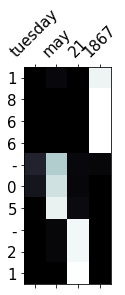

In [37]:
output_tokens , attention = translate_sentence('tuesday may 21 1867',t)
display_attention('tuesday may 21 1867',output_tokens,attention)

In [ ]:
rnn = nn.GRU(100,64, num_layers= 2 ,batch_first= True ,bidirectional=True)
inp = torch.randn((2,8,100))
outputs,hidden = rnn(inp)

In [ ]:
outputs.shape

In [ ]:
hidden.shape

In [ ]:
inq = torch.cat([hidden[-i , : , :] for i in range(4)],dim=1)


In [ ]:
inq.shape

In [ ]:
rnn(inp)[1].shape

In [ ]:
embedding_layer = nn.Embedding(10,30)

embedding_layer(torch.tensor([[10,2,3],[4,5,6]])).shape